# Part 3. (continued)

In [32]:
# restore  classifier
import auxil.dnn as dnn
classifier1 = dnn.Dnn() # dummy classifier object
classifier1.restore('classifier1.h5')

In [20]:
%matplotlib inline
import ee
ee.Initialize()
poly ={'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-104.61753499999999, 50.07797299999997], [-104.43980400000001, 50.07797299999997], [-104.43980400000001, 50.19341589285912], [-104.61753499999999, 50.19341589285912], [-104.61753499999999, 50.07797299999997]]]}
collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
                      .filterBounds(poly) \
                      .filterDate(ee.Date('2017-04-01'), ee.Date('2017-11-01')) \
                      .filter(ee.Filter.eq('transmitterReceiverPolarisation', ['VV','VH'])) \
                      .filter(ee.Filter.eq('resolution_meters', 10)) \
                      .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                      .filter(ee.Filter.eq('relativeOrbitNumber_start',5)) \
                      .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))  
collection.size().getInfo()

16

In [21]:
import math
def get_vvvh(image):   
    ''' get 'VV' and 'VH' bands from sentinel-1 imageCollection and restore linear signal from db-values '''
    return image.select('VV','VH').multiply(ee.Image.constant(math.log(10.0)/10.0)).exp()

timeseries_test = collection.map(get_vvvh).toBands().clip(poly).float()

In [23]:
crop2017 = ee.ImageCollection('AAFC/ACI') \
    .filter(ee.Filter.date('2017-01-01', '2017-12-31')) \
    .first() \
    .clip(timeseries_test.geometry())\
    .float()
labeled_timeseries_test = ee.Image.cat(timeseries_test,crop2017)

In [24]:
drexport = ee.batch.Export.image.toDrive(labeled_timeseries_test,
                  description='driveExportTask', 
                  folder = 'EarthEngineImages',
                  fileNamePrefix='labeled_timeseries_test',scale=10,maxPixels=1e9)
print('Exporting test timeseries to %s\n task id: %s'%('EarthEngineImages/labeled_timeseries_test',str(drexport.id)))
drexport.start()

Exporting test timeseries to EarthEngineImages/labeled_timeseries_test
 task id: 6PQLOTZXP7HZ3JRVY3SUJMQE


In [25]:
ls imagery/

AAFC.txt                             timeseries_class.tif
AST_20070501_pca_classprobs_plr.tif  timeseries_probs_plr.tif
AST_20070501_pca_classprobs.tif      timeseries_probs.tif
labeled_timeseries_test.tif          timeseries_test_class.tif
labeled_timeseries.tif               timeseries_test_probs_plr.tif
labels.tif                           timeseries_test_probs.tif
radarsat2bonn/                       timeseries_test.tif
southyorkshire/


In [28]:
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly, GDT_Byte
import numpy as np

gdal.AllRegister()                   
inDataset = gdal.Open('imagery/labeled_timeseries_test.tif',GA_ReadOnly)
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    
bands = inDataset.RasterCount
labeled_timeseries_test = np.zeros((rows*cols,bands))                              
for b in range(bands):
    band = inDataset.GetRasterBand(b+1)
    labeled_timeseries_test[:,b]=band.ReadAsArray(0,0,cols,rows).ravel()   
driver = inDataset.GetDriver() # for later    
inDataset = None
labeled_timeseries_test = np.nan_to_num(labeled_timeseries_test)

print(labeled_timeseries_test.shape)
m = labeled_timeseries_test.shape[0]
print(m)

(1653760, 33)
1653760


In [29]:
classnums = list(set(labeled_timeseries_test[:,-1]))
classnums.sort()
print(classnums)

[0.0, 20.0, 30.0, 34.0, 80.0, 110.0, 122.0, 136.0, 145.0, 146.0, 153.0, 154.0, 158.0, 162.0, 174.0, 196.0, 220.0]


In [30]:
i=0
labels = labeled_timeseries_test[:,-1]
for c in classnums:
    labels = np.where(labels==c,i,labels)
    i += 1  
labels = np.array(labels,dtype=np.uint8) 
print(set(labels))
n_classes = len(set(labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}


In [31]:
outDataset = driver.Create('imagery/labels_test.tif',cols,rows,1,GDT_Byte)
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(np.reshape(labels,(rows,cols)))
outBand.FlushCache()
outDataset = None

In [35]:
cls,Ms = classifier1.classify(labeled_timeseries_test[:,0:-1]*100) 
cls[0]=1
print(Ms.shape)

(1653760, 18)


In [36]:
# write the class image to disk
outDataset = driver.Create('imagery/timeseries_test_class.tif',cols,rows,1,GDT_Byte)
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(np.reshape(cls,(rows,cols)))
outBand.FlushCache()
outDataset = None
# write the class probabilities to disk
Ms = np.byte(Ms*255)
bands = Ms.shape[1]
outDataset = driver.Create('imagery/timeseries_test_probs.tif',cols,rows,bands,GDT_Byte)
for b in range(bands):
    outBand = outDataset.GetRasterBand(b+1)
    outBand.WriteArray(np.reshape(Ms[:,b],(rows,cols)))
    outBand.FlushCache()
outDataset = None

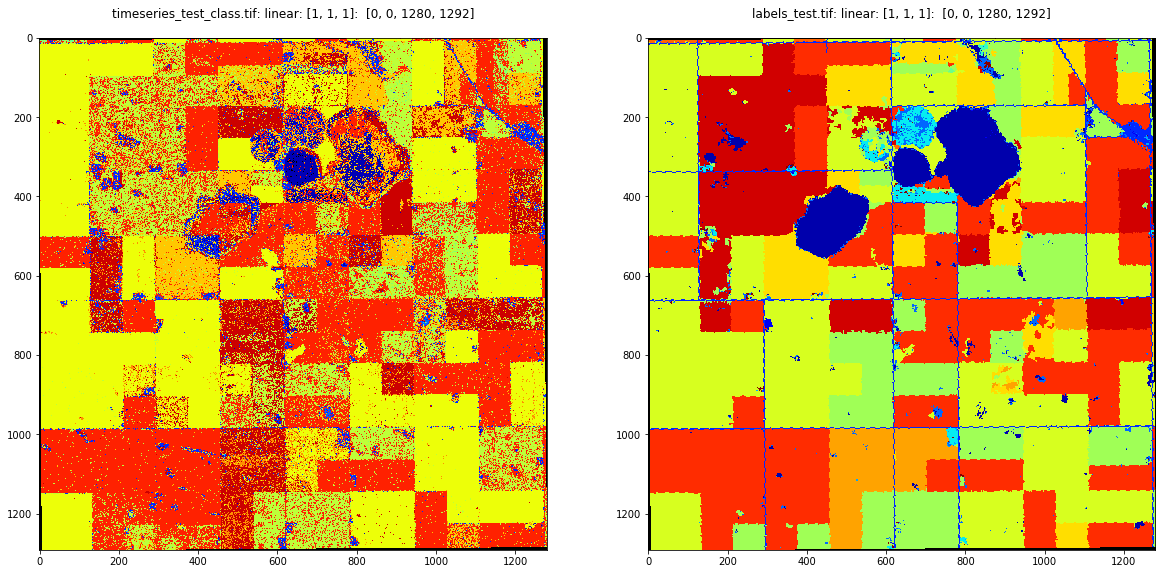

In [38]:
%run scripts/dispms -f imagery/timeseries_test_class.tif -c -F imagery/labels_test.tif -C

In [39]:
%run scripts/plr -i 5 imagery/timeseries_test_probs.tif

       PLR
infile:  imagery/timeseries_test_probs.tif
iterations:  5
estimating compatibility matrix...
label relaxation...
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
result written to: imagery/timeseries_test_probs_plr.tif
elapsed time: 209.26532554626465
--done------------------------


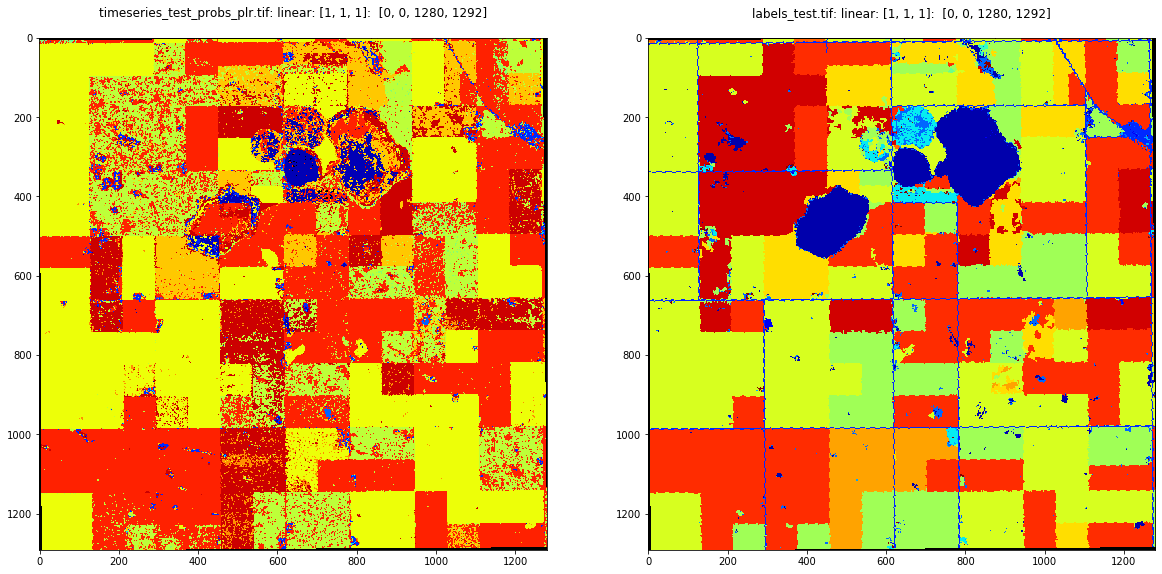

In [40]:
%run scripts/dispms -f imagery/timeseries_test_probs_plr.tif -c -F imagery/labels_test.tif -C